In [1]:
import pandas as pd
import numpy as np

from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gw_df = pd.read_csv('../data/richers_1764.csv')

# y-axis processing
distance = 3.086e22
gw_df = gw_df / distance

# x-axis processing
# for future use
sampling_period = 0.00024354078

### Analysis

#### Notes

- Signals truncated 0.04956055s before bounce and roughly 0.04956055s after bounce, as provided by Matt's research paper

- All y values are in distance * strain. Where all distances are 10 kpc or 3.086e22m. Strain is * 1e-21.

#### All Signals

In [ ]:
gw_df.plot(legend=False)

plt.xlabel('n (???)')
plt.ylabel('Strain (cm)')

# the core bounce is at n = 203
plt.axvline(x=203, color='black', linestyle='--', alpha=0.5)

plt.show()

#### 16 Random Signals

In [ ]:
# select 16 random signals
random_index = np.random.randint(0, gw_df.shape[1], 16)
selected_signals = gw_df.iloc[:, random_index]  # Assuming the first 64 columns are the signals

num_rows = 4
num_cols = 4

# Determine the common limits for all subplots
common_ylim = (selected_signals.min().min(), selected_signals.max().max())

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(len(selected_signals))
    y = selected_signals.iloc[:, i]
    ax.plot(x, y)

    ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {random_index[i]}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(len(selected_signals), num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

- All signals appear significantly different from one another
- There appears to be a common peak at n = 203 (core bounce)
- The core bounce is NOT necessarily the peak strain for each signal

#### General Distribution of signals

*Needs a lot of work, as I'm not sure whether I'm conveying information accurately*

In [ ]:
# convert the DataFrame from wide format to long format for seaborn
gw_df_long = pd.melt(gw_df.reset_index(), id_vars='index')

gw_df_long.columns = ['n (???)', 'Line', 'Strain (cm)']

# confidence intervals
sns.lineplot(x='n (???)', y='Strain (cm)', hue='Line', data=gw_df_long, errorbar=('ci', 95), n_boot=1000, legend=False)

median_line = gw_df.median(axis=1)
plt.plot(median_line.index, median_line.values, 'b-', label='median')

# the core bounce is at n = 203
plt.axvline(x=203, color='black', linestyle='--', alpha=0.5)  

plt.legend()
plt.show()

- Hard to reliably tell if there's a general trend of tension during core collapse
- Mean/median can be misleading with wave data 
- Waves typically dissipate entirely after n = 350
- Appears to have two main peaks, at n = 203 and n = 275

### Todo
- Figure out how to convey distribution of signals
- Frequency component
- Subset the data
    - Weak core collapse
    - Strong core collapse

- Convert n -> time (s)
- Analyse peaks
- Analyse settling times

### Spectral Analysis 

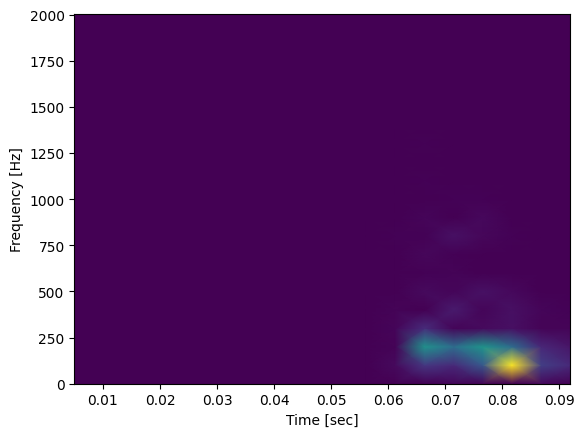

In [49]:
fs = 407/(0.04956055 * 2)
sample_random = gw_df['V6'].values

window_length = int(0.01 * fs)  # Example: 1% of the total duration
overlap = int(0.005 * fs)  # 50% overlap
f, t, Sxx = signal.spectrogram(sample_random, fs, nperseg=window_length, noverlap=overlap)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#### Test

In [7]:
rng = np.random.default_rng()

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

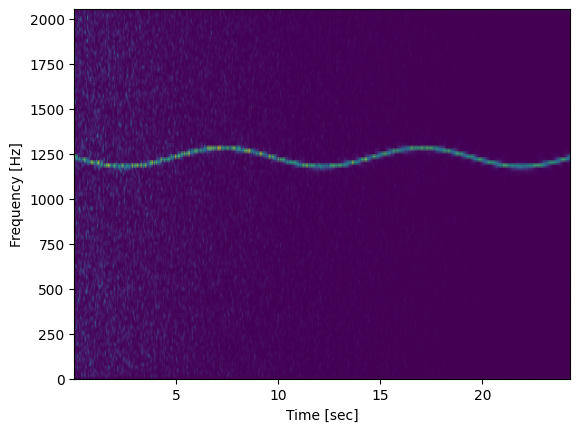

In [33]:
f, t, Sxx = signal.spectrogram(x, fs)
Sxx_normalized = (Sxx - np.min(Sxx)) / (np.max(Sxx) - np.min(Sxx))
plt.pcolormesh(t, f, Sxx_normalized, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()